In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    Batch,
)
from heisenberg_graph import HeisenbergModel, get_n_steps, get_graph, get_prob0
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.transpiler import Layout
import mthree
import pickle
import os
from datetime import datetime, timezone

In [3]:
n_qubits = 8
ghz_qubits = list(range(n_qubits // 2))

# total time to be simulated
# times = np.linspace(0, 10, 100)
times = np.linspace(0, 1.5, 5)

rng = np.random.default_rng(42)

## Create graph (Demo)

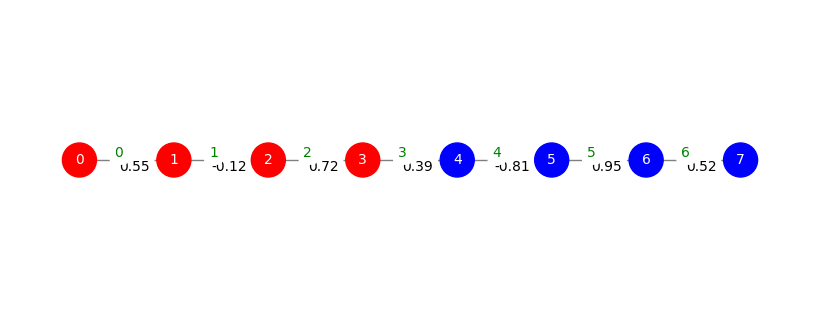

In [4]:
graph_type = "line"
G = get_graph(n_qubits, rng, ghz_qubits, graph_type)

# 等間隔に配置するためのカスタム座標を定義
if graph_type == "tree":
    if n_qubits == 10:
        positions = {
            0: (3, 1),
            1: (4, 1),
            2: (5, 1),
            3: (3, 2),
            4: (2, 1),
            5: (1, 1),
            6: (0, 1),
            7: (1, 0),
            8: (5, 0),
            9: (6, 1),
        }
    elif n_qubits == 8:
        positions = {
            0: (3, 0),
            1: (4, 0),
            2: (5, 0),
            3: (2, 0),
            4: (3, 1),
            5: (1, 0),
            6: (0, 0),
            7: (6, 0),
        }
    elif n_qubits == 4:
        positions = {
            0: (0, 0),
            1: (1, 0),
            2: (2, 0),
            3: (0, 1),
        }
elif graph_type == "line":
    positions = {i: (i, 0) for i in range(n_qubits)}

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_operation_order_labels = {
    edge: f"{G.edges[edge]['operation_order']}" for edge in G.edges
}

# グラフを描画
plt.figure(figsize=(8, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["GHZ"] else "blue" for node in G.nodes],
    node_size=600,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'operation_order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_operation_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.4,
    verticalalignment="bottom",
)

plt.show()

In [5]:
# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, operational=True)
backend_qpu = service.backend("ibm_brisbane")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()
noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_brisbane')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['measure', 'reset', 'sx', 'id', 'ecr', 'x']>)


In [6]:
current_time = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

os.makedirs(
    f"./test_data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}",
    exist_ok=True,
)

## Exact

In [7]:
probs_exact = []
heisenberg_exact = HeisenbergModel(n_qubits, G)

for t in times:
    n_steps = get_n_steps(t)
    prob_exact = heisenberg_exact.exact_simulation(t, phase=0)
    probs_exact.append(prob_exact)

## Simulator (Noise free)

In [8]:
heisenberg_sim = HeisenbergModel(n_qubits, G, backend_sim)
circuits = []
isa_circuits = []

for t in times:
    n_steps = get_n_steps(t)

    # For debug, we can get the circuit and ISA circuit from the simulator
    circuit, isa_circuit = heisenberg_sim.get_trotter_simulation_pub(
        t, n_steps, phase=0
    )
    circuits.append(circuit)
    isa_circuits.append(isa_circuit)

In [9]:
with Batch(backend=backend_sim):
    sampler = Sampler()
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(isa_circuits)
    print(f"job_id: {job.job_id()}")

job_id: c2de7870-0e6c-4715-80fd-dd960ef6f4e4


/Users/yutotakaki/Desktop/fourier_learning_ibm/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [10]:
# Post-processing
probs_sim = []

for result in job.result():
    prob0 = get_prob0(result, n_qubits)
    probs_sim.append(prob0)

## Simulator (Noisy)

In [11]:
heisenberg_sim_noisy = HeisenbergModel(n_qubits, G, backend_sim)
circuits = []
isa_circuits = []

for t in times:
    n_steps = get_n_steps(t)

    circuit, isa_circuit = heisenberg_sim_noisy.get_trotter_simulation_pub(
        t, n_steps, phase=0
    )
    circuits.append(circuit)
    isa_circuits.append(isa_circuit)

In [12]:
with Batch(backend=backend_sim_noisy):
    sampler = Sampler()
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(isa_circuits)
    print(f"job_id: {job.job_id()}")

job_id: 7c92b1b1-a357-4252-aa0f-5cc190953367


/Users/yutotakaki/Desktop/fourier_learning_ibm/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [13]:
# Post-processing
probs_sim_noisy = []

for result in job.result():
    prob0 = get_prob0(result, n_qubits)
    probs_sim_noisy.append(prob0)

## QPU

In [17]:
heisenberg_qpu = HeisenbergModel(n_qubits, G, backend_qpu)
circuits_qpu = []
isa_circuits_qpu = []

if graph_type == "tree":
    if backend_qpu.name == "ibm_brisbane":
        if n_qubits == 10:
            initial_layout = [60, 61, 62, 53, 59, 58, 57, 71, 72, 63]
        elif n_qubits == 8:
            initial_layout = [60, 61, 62, 59, 53, 58, 57, 63]
        elif n_qubits == 4:
            initial_layout = [60, 61, 62, 53]
elif graph_type == "line":
    initial_layout = list(range(n_qubits))


for t in times:
    n_steps = get_n_steps(t)

    circuit, isa_circuit = heisenberg_qpu.get_trotter_simulation_pub(
        t, n_steps, phase=0, initial_layout=initial_layout
    )
    circuits_qpu.append(circuit)
    isa_circuits_qpu.append(isa_circuit)

before transpile
circuit depth: 32
count_ops: OrderedDict([('cx', 20), ('measure', 8), ('rx', 7), ('rz', 7), ('rzx', 7), ('h', 2), ('barrier', 1)])


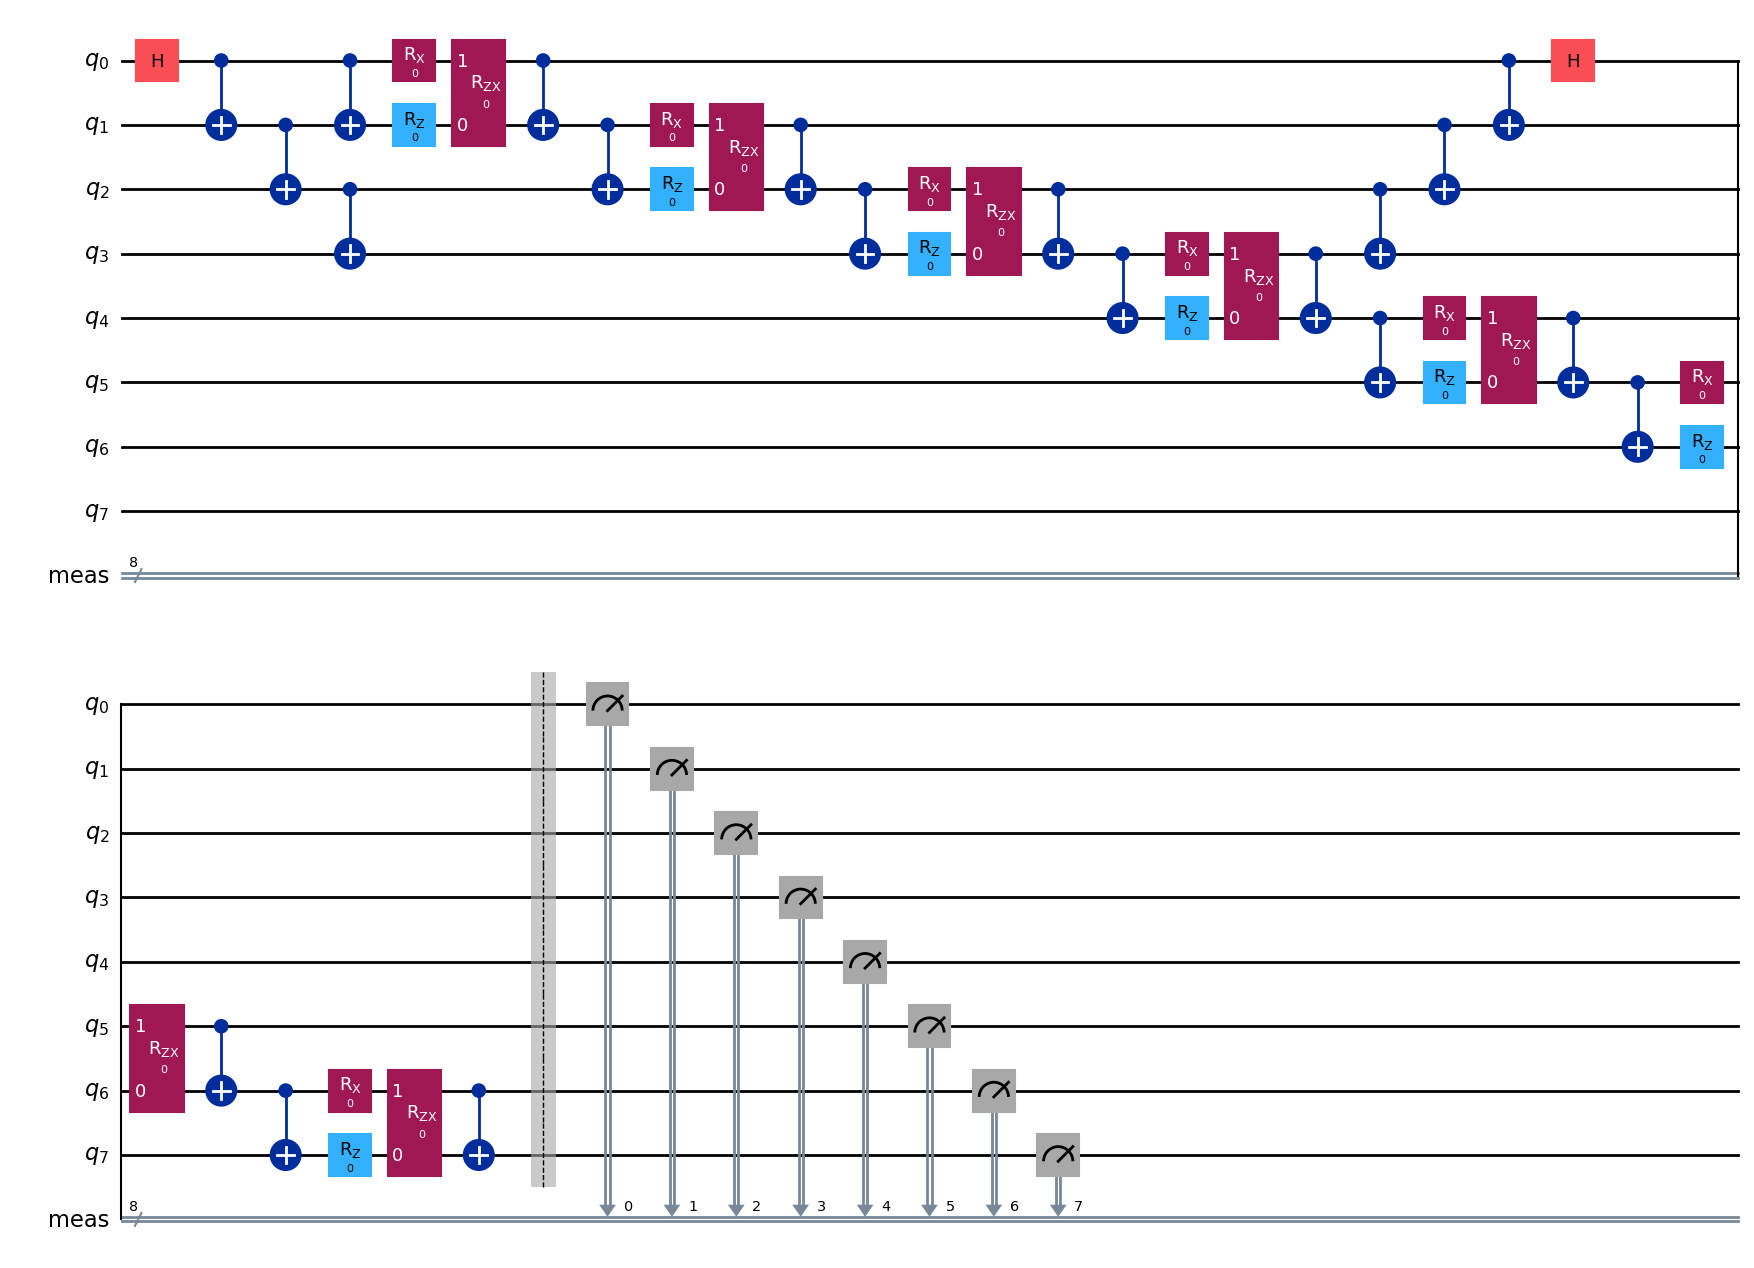

In [18]:
print("before transpile")
print(f"circuit depth: {circuits_qpu[0].depth()}")
print(f"count_ops: {circuits_qpu[0].count_ops()}")
circuits_qpu[0].draw("mpl")

after transpile
circuit depth: 100
count_ops: OrderedDict([('rz', 85), ('sx', 55), ('ecr', 34), ('x', 15), ('measure', 8), ('barrier', 1)])


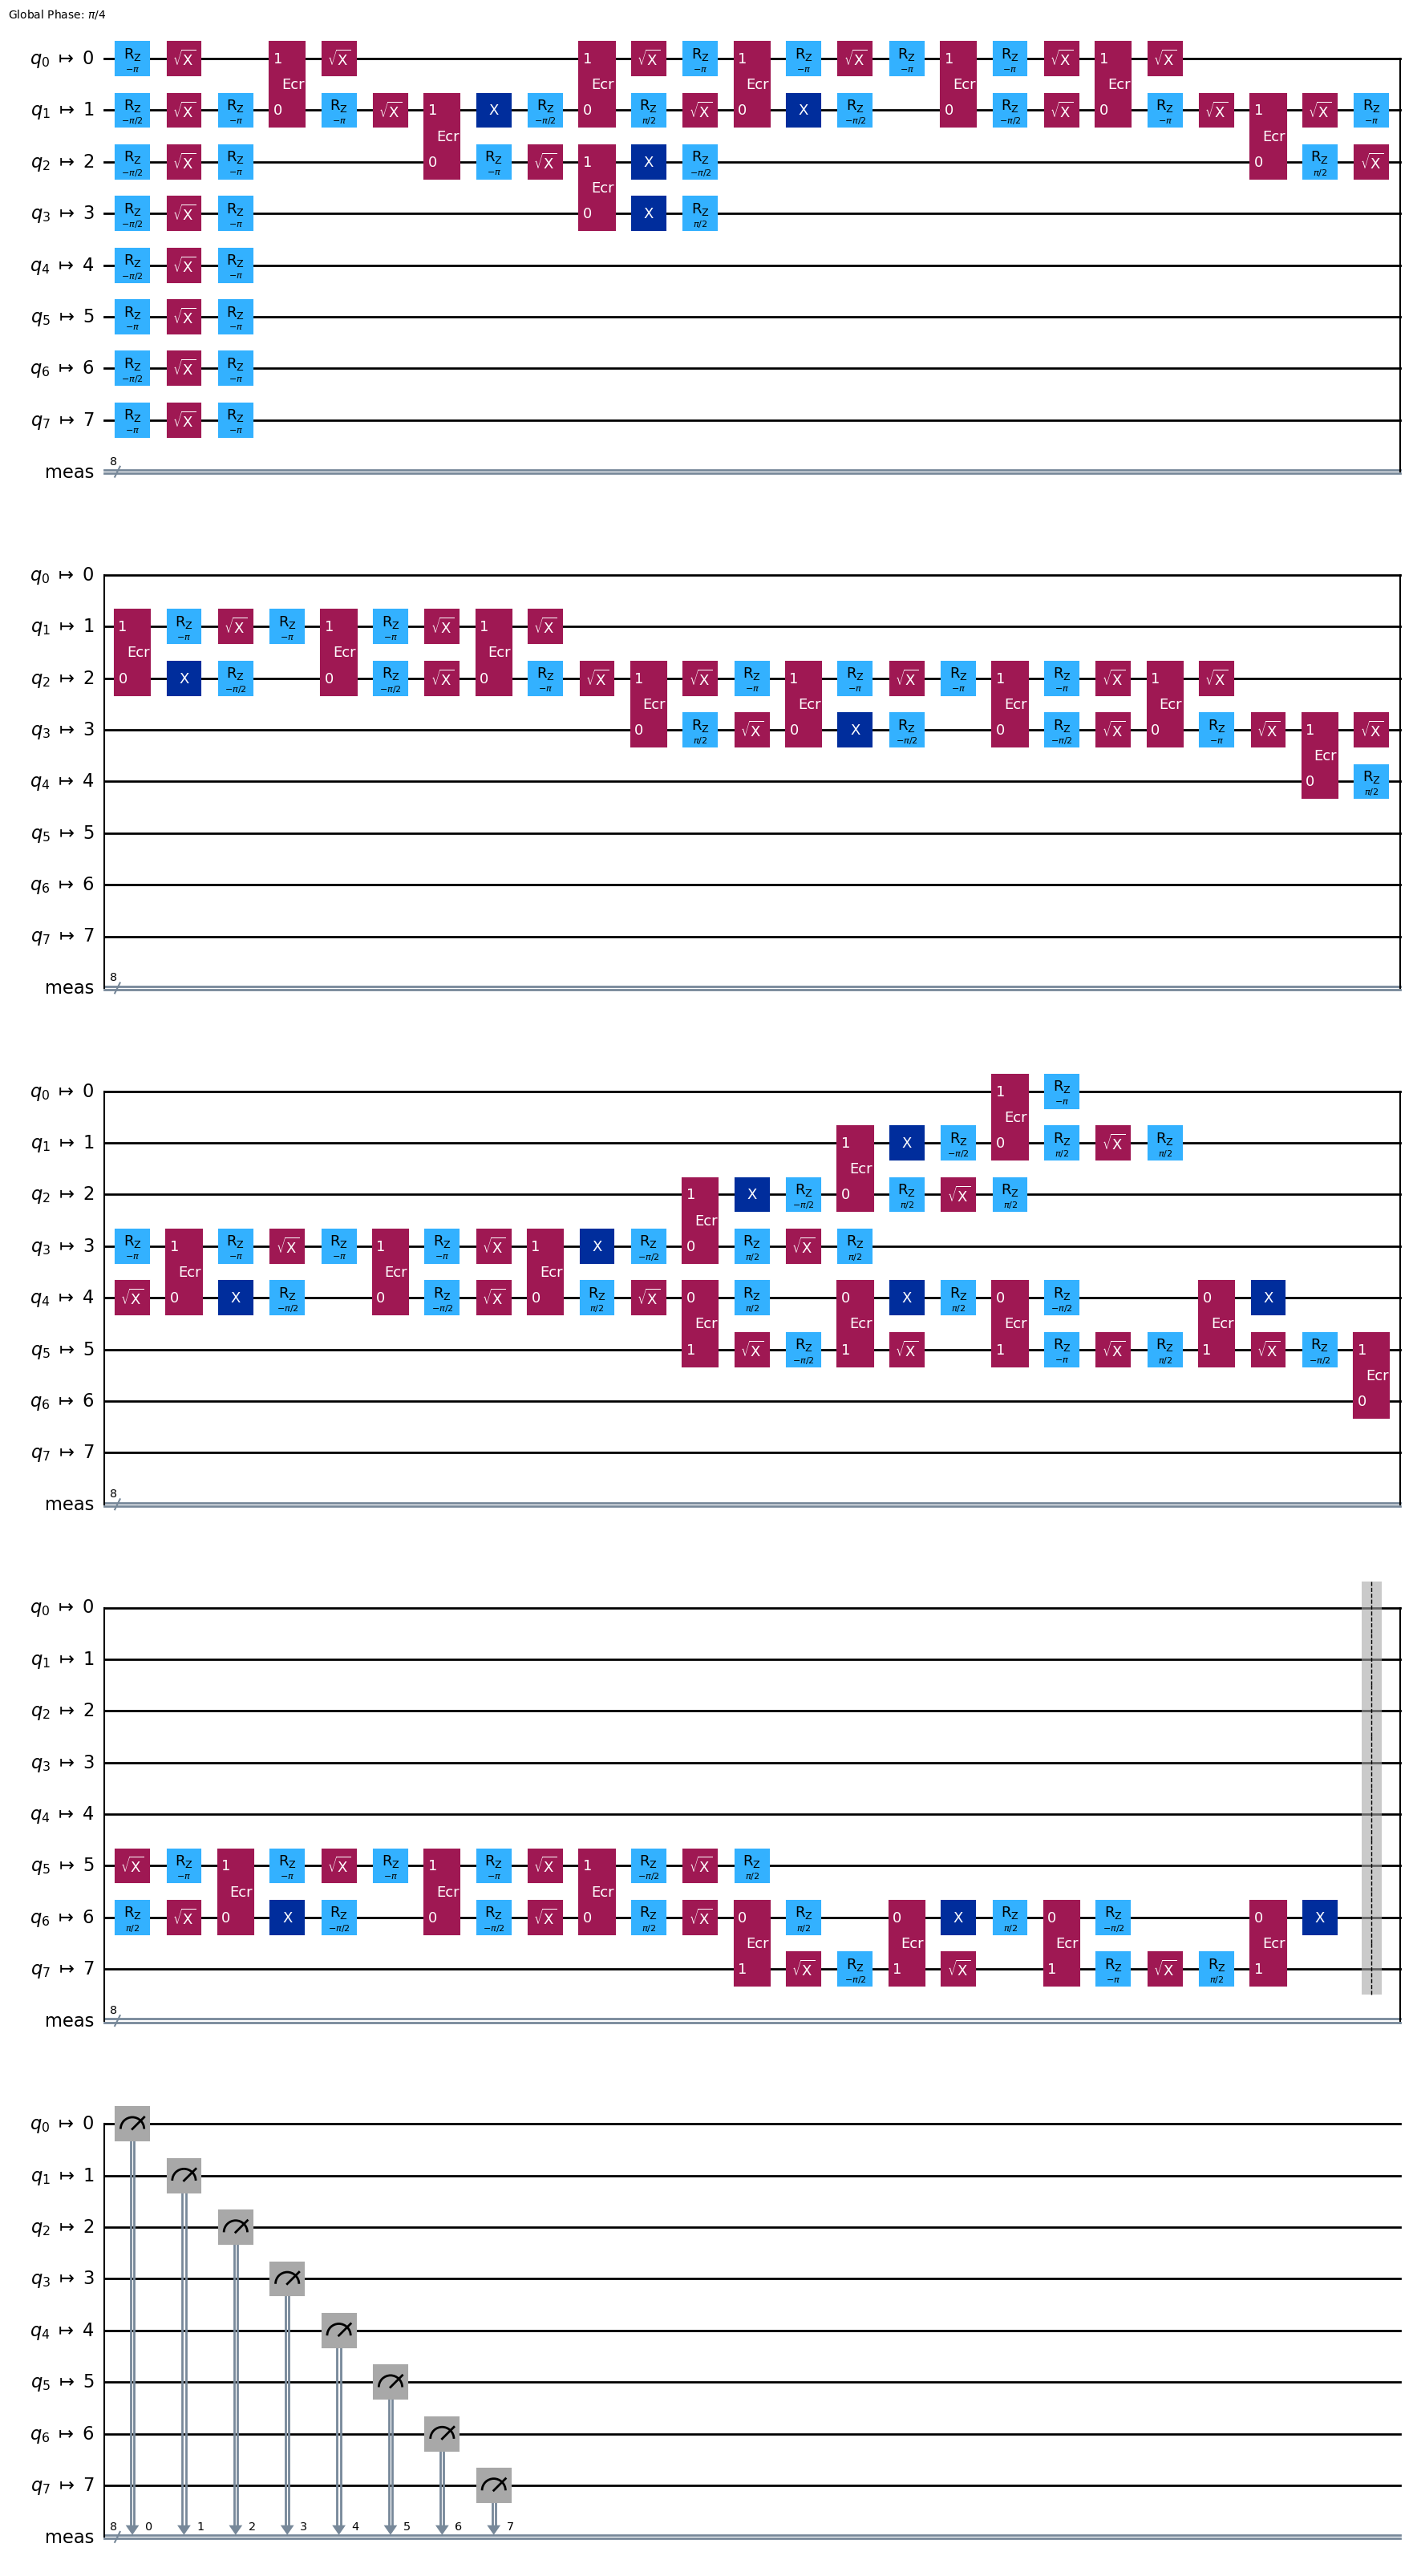

In [19]:
print("after transpile")
print(f"circuit depth: {isa_circuits_qpu[0].depth()}")
print(f"count_ops: {isa_circuits_qpu[0].count_ops()}")
isa_circuits_qpu[0].draw("mpl", idle_wires=False)

In [20]:
# Run a job in a batch
mit = mthree.M3Mitigation(backend_qpu)
with Batch(backend=backend_qpu) as batch:
    sampler = Sampler()
    mit.cals_from_system(runtime_mode=batch)
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    # Run job.
    job = sampler.run(isa_circuits_qpu)
    print(f"job_id: {job.job_id()}")

job_id: cwwp060tdtng0087e9a0


In [21]:
started_at = batch.details()["started_at"]
with open(
    f"./test_data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}/job_id_qpu.txt",
    "w",
) as f:
    f.write(job.job_id())
mit.cals_to_file(
    f"./test_data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}/calibrations_{started_at}.json"
)

print(f"current_time: {current_time}")
print(f"started_at: {started_at}")

current_time: 2024-11-17T03:14Z
started_at: 2024-11-17T03:16:37.195Z


## Below should be run after first running

In [22]:
# Retrieve the job
# Copy and paste the output of the above cell
current_time = "2024-11-17T03:14Z"
started_at = "2024-11-17T03:16:37.195Z"

with open(
    f"./test_data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}/job_id_qpu.txt",
    "r",
) as f:
    job_id = f.read()

job = service.job(job_id)

In [23]:
# Apply mititation
probs_qpu_nmit = []
probs_qpu_mit = []

cals_file = f"./test_data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}/calibrations_{started_at}.json"
mit = mthree.M3Mitigation(backend_qpu)
mit.cals_from_file(cals_file)

for result in job.result():
    prob0_nmit, prob0_mit = get_prob0(result, n_qubits, mit)
    probs_qpu_nmit.append(prob0_nmit)
    probs_qpu_mit.append(prob0_mit)

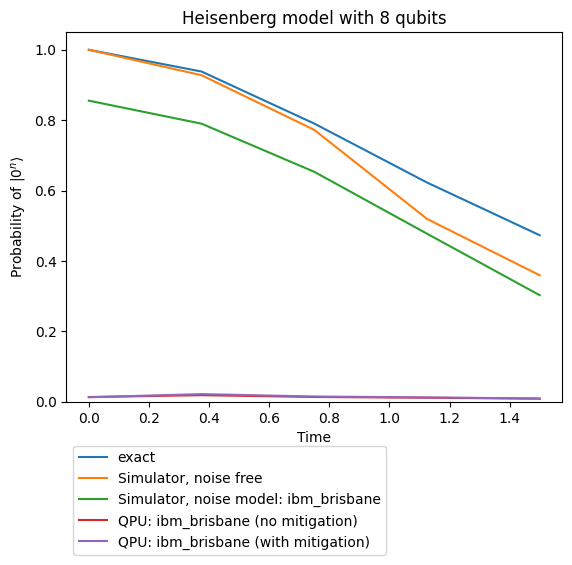

In [27]:
# Plot the results
plt.plot(times, probs_exact, label="exact")
plt.plot(times, probs_sim, label=f"Simulator, noise free")
plt.plot(times, probs_sim_noisy, label=f"Simulator, noise model: {backend_qpu.name}")
plt.plot(times, probs_qpu_nmit, label=f"QPU: {backend_qpu.name} (no mitigation)")
plt.plot(times, probs_qpu_mit, label=f"QPU: {backend_qpu.name} (with mitigation)")
plt.title(f"Heisenberg model with {n_qubits} qubits")
plt.ylim(0, 1.05)
plt.xlabel("Time")
plt.ylabel("Probability of $|0^n\\rangle$")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.show()